In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import torch
from env import Box

import matplotlib.pyplot as plt
import numpy as np

from TruncatedNormal import TruncatedNormal

In [102]:
env = Box(dim=2, device_str="cpu")

In [103]:
# Create a meshgrid of states in [0, 1]^2 in torch
n = 100
x = torch.linspace(0, 1, n)
y = torch.linspace(0, 1, n)
xx, yy = torch.meshgrid(x, y)
states = torch.stack([xx, yy], dim=-1).reshape(-1, 2)
states.shape

torch.Size([10000, 2])

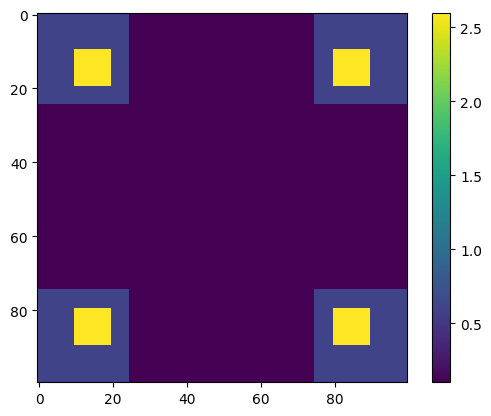

In [104]:
rewards  = env.reward(states)
plt.imshow(rewards.reshape(n, n))
plt.colorbar()
plt.show()

In [106]:
env.reward(torch.zeros(2)).log()

tensor(-0.5108)

In [6]:
N_TRAJ = 10

In [5]:
actions_sampler = RandomActionsSampler(env, terminal_action_prob=0.1)
trajectories_sampler = TrajectoriesSampler(env, actions_sampler)

In [6]:
trajectories, actionss, logprobs = trajectories_sampler.sample(N_TRAJ)

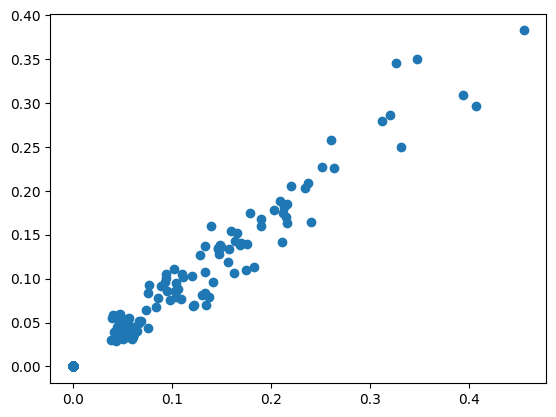

In [16]:
states = get_last_states(env, trajectories)
# scatter plot of the last states
plt.scatter(states[:, 0], states[:, 1])

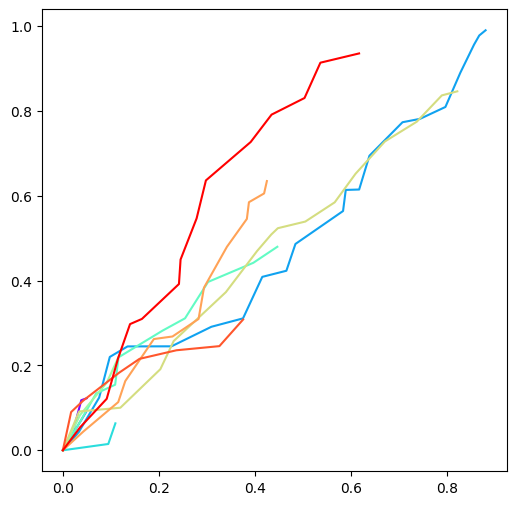

In [8]:
# make a figure of size 6, 6
plt.figure(figsize=(6, 6))
# list of 10 different colors
colors = plt.cm.rainbow(np.linspace(0, 1, N_TRAJ))
for i in range(10):
    plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], color=colors[i])

In [8]:

model = BoxModel(logvar=False)
actions_sampler = NNActionsSampler(env, model, std=0.1)


In [11]:
trajectories_sampler = TrajectoriesSampler(env, actions_sampler)

In [18]:
trajectories, actionss, logprobs = trajectories_sampler.sample(10)

In [19]:
logprobs

tensor([-0.7129, -0.0591,  1.2486, -0.7129, -0.7129, -0.7129,  0.7952, -0.7129,
        -0.7129, -0.7129], grad_fn=<AddBackward0>)

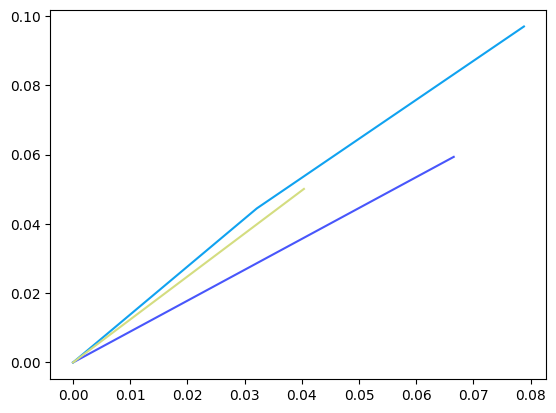

In [20]:
# list of 10 different colors
colors = plt.cm.rainbow(np.linspace(0, 1, N_TRAJ))
for i in range(10):
    plt.plot(trajectories[i, :, 0], trajectories[i, :, 1], color=colors[i])

In [9]:
bw_model = BoxModel(logvar=False)


In [12]:
lr = 1e-3
lr_Z = 5e-2
BS = 256
logZ = torch.zeros(1, requires_grad=True)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer.add_param_group({"params": bw_model.parameters(), "lr": lr})
optimizer.add_param_group({"params": [logZ], "lr": lr_Z})

for i in range(int(1e5)):
    optimizer.zero_grad()
    trajectories, actionss, logprobs = trajectories_sampler.sample(BS)
    last_states = get_last_states(env, trajectories)
    logrewards = env.reward(last_states).log()
    bw_logprobs = evaluate_backward_logprobs(env, bw_model, trajectories, actionss, bw_std=0.1)
    loss = torch.mean((logZ + logprobs - bw_logprobs - logrewards) ** 2)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        print(loss.item())

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [298]], which is output 0 of SigmoidBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [23]:
trajectories

tensor([[[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [0.0666, 0.0593],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [0.0321, 0.0445],
         [0.0788, 0.0969],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [0.0404, 0.0501],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[

In [24]:
non_sink = ~torch.all(trajectories == env.sink_state, dim=-1)

trajectories[non_sink]

tensor([[0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0666, 0.0593],
        [0.0000, 0.0000],
        [0.0321, 0.0445],
        [0.0788, 0.0969],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0404, 0.0501],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])

In [25]:
non_sink

tensor([[ True, False, False, False],
        [ True,  True, False, False],
        [ True,  True,  True, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True,  True, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])

In [46]:
non_sink.cumsum(dim=-1).argmax(dim=-1)

tensor([0, 1, 2, 0, 0, 0, 1, 0, 0, 0])

In [47]:
mask = torch.zeros_like(non_sink).bool()
mask.scatter_(1, non_sink.cumsum(dim=-1).argmax(dim=-1, keepdim=True), True)

tensor([[ True, False, False, False],
        [False,  True, False, False],
        [False, False,  True, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [False,  True, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])

In [49]:
trajectories[mask]

tensor([[0.0000, 0.0000],
        [0.0666, 0.0593],
        [0.0788, 0.0969],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0404, 0.0501],
        [0.0000, 0.0000],
        [0.0000, 0.0000],
        [0.0000, 0.0000]])

In [36]:
last_non_sink

tensor([[[0., 0.],
         [-inf, -inf],
         [-inf, -inf],
         [0., 0.],
         [0., 0.],
         [0., 0.],
         [-inf, -inf],
         [0., 0.],
         [0., 0.],
         [0., 0.]]])

In [37]:
trajectories

tensor([[[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [0.0666, 0.0593],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [0.0321, 0.0445],
         [0.0788, 0.0969],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [0.0404, 0.0501],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[0.0000, 0.0000],
         [  -inf,   -inf],
         [  -inf,   -inf],
         [  -inf,   -inf]],

        [[

In [5]:
from torch.distributions import Beta, MixtureSameFamily, Categorical, Independent

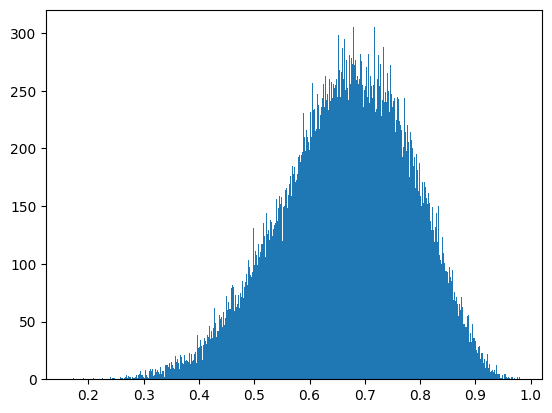

In [21]:
beta = Beta(torch.tensor([10.0]), torch.tensor([5.0]))
plt.hist(beta.sample((100000,)).numpy(), bins=1000)
plt.show()

In [36]:
tru = TruncatedNormal(torch.tensor([[0.8], [0.2]]), torch.tensor([[0.1], [0.05]]),
 torch.tensor([[0.0], [0.0]]), torch.tensor([[1.0], [1.0]]))

tutu = Independent(tru, 1)

mixture_dist = MixtureSameFamily(Categorical(torch.tensor([0.5, 0.5])), tutu)



plt.plot(torch.linspace(0, 1, 1000).numpy(), mixture_dist.log_prob(torch.linspace(0, 1, 1000)).exp().numpy())



ValueError: The right-most size of value must match event_shape: torch.Size([1000]) vs torch.Size([1]).

In [37]:
tru.sample()

tensor([[0.8207],
        [0.2235]])

In [67]:
mixture_dist.log_prob(mixture_dist.sample(torch.Size([3])))

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

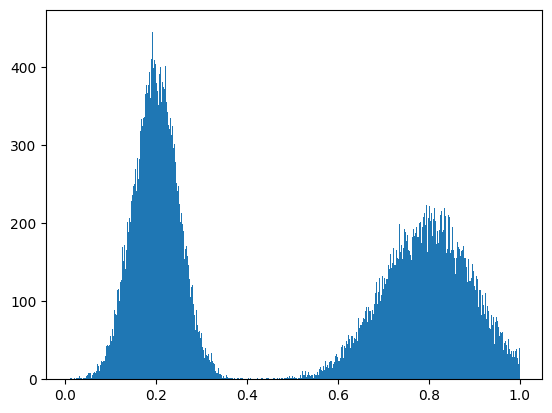

In [64]:
plt.hist(mixture_dist.sample((100000,)).numpy(), bins=1000)
plt.show()


In [61]:
mixture_dist.log_prob(torch.linspace(0, 1, 3).unsqueeze(-1))

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

In [56]:
torch.linspace(0, 1, 2).unsqueeze(-1)

tensor([[0.],
        [1.]])

In [90]:
alphas = torch.tensor([1.2, 1.3])
betas = torch.tensor([1.0, 1.0])

alphas_2 = torch.tensor([[1.2, 1.3], [1.2, 1.3]])
betas_2 = torch.tensor([[1.0, 1.0], [1.0, 1.0]])

beta = Beta(alphas, betas)
beta_2 = Independent(Beta(alphas_2, betas_2), 1)

In [95]:
xx = beta_2.sample()

In [96]:
beta_2.log_prob(xx)

tensor([-0.1928,  0.3833])

In [101]:
beta.log_prob(xx[1])

tensor([0.1270, 0.2563])

In [97]:
xx

tensor([[0.2572, 0.2953],
        [0.7584, 0.9800]])